### 1. Objective (loss) functions and base learners
* Let's talk a bit about objective functions and base learners so we can develop better intuitions about both concepts, as they are critical to understand in order for you to be able to grasp why XGBoost is such a powerful approach to building supervised regression models.

### 2. Objective Functions and Why We Use Them
* An objective or loss function quantifies how far off our prediction is from the actual result for a given data point. It maps the difference between the prediction and the target to a real number. When we construct any machine learning model, we do so in the hopes that it minimizes the loss function across all of the data points we pass in. That's our ultimate goal, the smallest possible loss.

### 3. Common loss functions and XGBoost
* Loss functions have specific naming conventions in XGBoost. For regression models, the most common loss function used is called reg linear. For binary classification models, the most common loss functions used are reg logistic, when you simply want the category of the target, and binary logistic, when you want the actual predicted probability of the positive class. So, in chapter 1, we were implicitly using the reg logistic loss function when building our classification models in XGBoost.


In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import xgboost as xgb

In [3]:
housing = pd.read_csv('../ames_housing_trimmed_processed.csv')
housing.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,Remodeled,GrLivArea,BsmtFullBath,BsmtHalfBath,...,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,PavedDrive_P,PavedDrive_Y,SalePrice
0,60,65.0,8450,7,5,2003,0,1710,1,0,...,0,0,0,0,1,0,0,0,1,208500
1,20,80.0,9600,6,8,1976,0,1262,0,1,...,0,1,0,0,0,0,0,0,1,181500
2,60,68.0,11250,7,5,2001,1,1786,1,0,...,0,0,0,0,1,0,0,0,1,223500
3,70,60.0,9550,7,5,1915,1,1717,1,0,...,0,0,0,0,1,0,0,0,1,140000
4,60,84.0,14260,8,5,2000,0,2198,1,0,...,0,0,0,0,1,0,0,0,1,250000


In [4]:
X, y = housing.iloc[:,:-1], housing.iloc[:,-1]

In [5]:
from sklearn.metrics import mean_squared_error

# Create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Instantiate the XGBRegressor: xg_reg
xg_reg = xgb.XGBRegressor(objective="reg:linear", seed=123,n_estimators=10)

# Fit the regressor to the training set
xg_reg.fit(X_train, y_train)

# Predict the labels of the test set: preds
preds = xg_reg.predict(X_test)

# Compute the rmse: rmse
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

[14:27:06] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 28106.463641


## Linear base learners

Now that you've used trees as base models in XGBoost, let's use the other kind of base model that can be used with XGBoost - a linear learner. This model, although not as commonly used in XGBoost, allows you to create a regularized linear regression using XGBoost's powerful learning API. However, because it's uncommon, you have to use XGBoost's own non-scikit-learn compatible functions to build the model, such as xgb.train().

In order to do this you must create the parameter dictionary that describes the kind of booster you want to use (similarly to how you created the dictionary in Chapter 1 when you used xgb.cv()). The key-value pair that defines the booster type (base model) you need is "booster":"gblinear".

Once you've created the model, you can use the .train() and .predict() methods of the model just like you've done in the past.

Here, the data has already been split into training and testing sets, so you can dive right into creating the DMatrix objects required by the XGBoost learning API.

**Instructions**

* Create two DMatrix objects - DM_train for the training set (X_train and y_train), and DM_test (X_test and y_test) for the test set.
* Create a parameter dictionary that defines the "booster" type you will use ("gblinear") as well as the "objective" you will minimize ("reg:linear").
* Train the model using xgb.train(). You have to specify arguments for the following parameters: params, dtrain, and num_boost_round. Use 5 boosting rounds.
* Predict the labels on the test set using xg_reg.predict(), passing it DM_test. Assign to preds.
* Hit 'Submit Answer' to view the RMSE!


In [6]:
# Convert the training and testing sets into DMatrixes: DM_train, DM_test
DM_train = xgb.DMatrix(data=X_train, label=y_train)
DM_test =  xgb.DMatrix(data=X_test, label=y_test)

# Create the parameter dictionary: params
params = {"booster":"gblinear", "objective":"reg:linear"}

# Train the model: xg_reg
xg_reg = xgb.train(params = params, dtrain=DM_train, num_boost_round=5)

# Predict the labels of the test set: preds
preds = xg_reg.predict(DM_test)

# Compute and print the RMSE
rmse = np.sqrt(mean_squared_error(y_test,preds))
print("RMSE: %f" % (rmse))

[14:30:14] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 44289.208625


## Evaluating model quality

It's now time to begin evaluating model quality.

Here, you will compare the RMSE and MAE of a cross-validated XGBoost model on the Ames housing data. As in previous exercises, all necessary modules have been pre-loaded and the data is available in the DataFrame df. 

In [7]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:linear", "max_depth":4}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=4, num_boost_round=5, metrics='rmse', as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Extract and print final boosting round metric
print((cv_results["test-rmse-mean"]).tail(1))

[14:32:58] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:58] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:58] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:59] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
   train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0    141767.531250      429.448328   142980.433594    1193.789595
1    102832.542969      322.468977   104891.392578    1223.157953
2     75872.617188      266.473250    79478.937500    1601.344539
3     57245.650391      273.625907    62411.924804    2220.148314
4     44401.295899      316.422824    51348.281250    2963.379118
4    51348.28125
Name: test-rmse-mean, dtype: float64


In [8]:
# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=4, num_boost_round=5, metrics='mae', as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Extract and print final boosting round metric
print((cv_results["test-mae-mean"]).tail(1))

[14:34:36] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:37] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:37] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:37] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
   train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
0   127343.570312     668.342645  127633.992188   2403.993258
1    89770.054688     456.951613   90122.498047   2107.907095
2    63580.789063     263.407042   64278.559570   1887.564512
3    45633.140625     151.885298   46819.169922   1459.812547
4    33587.091797      87.000675   35670.649414   1140.607648
4    35670.649414
Name: test-mae-mean, dtype: float64


In [9]:
cv_results

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,127343.570312,668.342645,127633.992188,2403.993258
1,89770.054688,456.951613,90122.498047,2107.907095
2,63580.789063,263.407042,64278.559570,1887.564512
3,45633.140625,151.885298,46819.169922,1459.812547
4,33587.091797,87.000675,35670.649414,1140.607648


## Using regularization in XGBoost

Having seen an example of l1 regularization in the video, you'll now vary the l2 regularization penalty - also known as "lambda" - and see its effect on overall model performance on the Ames housing dataset.

**Instructions**

- Create your DMatrix from X and y as before.
- Create an initial parameter dictionary specifying an "objective" of "reg:linear" and "max_depth" of 3.
- Use xgb.cv() inside of a for loop and systematically vary the "lambda" value by passing in the current l2 value (reg).
- Append the "test-rmse-mean" from the last boosting round for each cross-validated xgboost model.
- Hit 'Submit Answer' to view the results. What do you notice?


In [3]:
boston_data = pd.read_csv("../ames_housing_trimmed_processed.csv")
X, y = boston_data.iloc[:,:-1],boston_data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=123)

In [4]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

reg_params = [1, 10, 100]

# Create the initial parameter dictionary for varying l2 strength: params
params = {"objective":"reg:linear","max_depth":3}

# Create an empty list for storing rmses as a function of l2 complexity
rmses_l2 = []

# Iterate over reg_params
for reg in reg_params:

    # Update l2 strength
    params["lambda"] = reg
    
    # Pass this updated param dictionary into cv
    cv_results_rmse = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=2, num_boost_round=5, metrics="rmse", as_pandas=True, seed=123)
    
    # Append best rmse (final round) to rmses_l2
    rmses_l2.append(cv_results_rmse["test-rmse-mean"].tail(1).values[0])

# Look at best rmse per l2 param
print("Best rmse as a function of l2:")
print(pd.DataFrame(list(zip(reg_params, rmses_l2)), columns=["l2","rmse"]))

[14:57:13] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:57:13] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:57:13] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:57:13] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:57:13] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:57:13] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
Best rmse as a function of l2:
    l2          rmse
0    1  52275.357421
1   10  57746.066406
2  100  76624.628907


In [14]:
%pip install graphviz

     |████████████████████████████████| 46 kB 823 kB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


[14:57:24] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

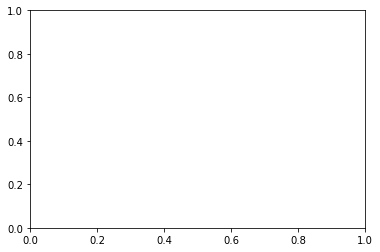

In [6]:
import matplotlib.pyplot as plt

# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:linear", "max_depth":2}

# Train the model: xg_reg
xg_reg = xgb.train(params=params, dtrain=housing_dmatrix, num_boost_round=10)

# Plot the first tree
xgb.plot_tree(xg_reg, num_trees=0)
plt.show()

# Plot the fifth tree
xgb.plot_tree(xg_reg, num_trees=4)
plt.show()

# Plot the last tree sideways
xgb.plot_tree(xg_reg, num_trees=9, rankdir='LR')
plt.show()

## Visualizing feature importances: What features are most important in my dataset

Another way to visualize your XGBoost models is to examine the importance of each feature column in the original dataset within the model.

One simple way of doing this involves counting the number of times each feature is split on across all boosting rounds (trees) in the model, and then visualizing the result as a bar graph, with the features ordered according to how many times they appear. XGBoost has a plot_importance() function that allows you to do exactly this, and you'll get a chance to use it in this exercise!

**Instructions**

* Create your DMatrix from X and y as before.
* Create a parameter dictionary with appropriate "objective" ("reg:linear") and a "max_depth" of 4.
* Train the model with 10 boosting rounds, exactly as you did in the previous exercise.
* Use xgb.plot_importance() and pass in the trained model to generate the graph of feature importances.



[14:58:31] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


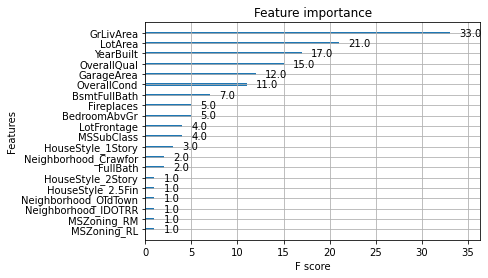

In [7]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:linear", "max_depth":4}

# Train the model: xg_reg
xg_reg = xgb.train(params=params, dtrain=housing_dmatrix, num_boost_round=10)

# Plot the feature importances
xgb.plot_importance(xg_reg)
plt.show()